# Linear Frequency-Dependent PTO 

In [1]:
import os
import logging

import matplotlib.pyplot as plt
import capytaine as cpy
from autograd.builtins import isinstance, tuple, list, dict
import autograd.numpy as np

import wecopttool as wot


# logging 
logging.basicConfig(level=logging.INFO)

# create save directory
results_dir = 'results_linear_freqdep_pto'
if not os.path.exists(results_dir):
  os.makedirs(results_dir)

# frequencies
f0 = 0.05
nfreq = 50

### WEC

In [2]:
## WEC object
# mesh
wb = wot.geom.WaveBot() 
mesh_size_factor = 0.5 
mesh = wb.mesh(mesh_size_factor)

# floating body
fb = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
fb.add_translation_dof(name="HEAVE")

# hydrostatics
hs_data = wot.hydrostatics.hydrostatics(fb)
mass_33 = wot.hydrostatics.mass_matrix_constant_density(hs_data)[2, 2]
mass = np.atleast_2d(mass_33)
stiffness_33 = wot.hydrostatics.stiffness_matrix(hs_data)[2, 2]
stiffness = np.atleast_2d(stiffness_33)

# WEC object
wec = wot.WEC(fb, mass, stiffness, f0, nfreq)

# BEM
fname = os.path.join(results_dir, 'bem.nc')
if os.path.exists(fname):
    wec.read_bem(fname)
else:
    wec.run_bem()
    wec.write_bem(fname)

INFO:capytaine.bodies.bodies:Stored 1054 triangle faces as quadrilaterals
INFO:capytaine.bodies.bodies:New floating body: WaveBot.
INFO:wecopttool.core:Changing value of 'f_add'. This might cause some attributes to be reset.
INFO:wecopttool.core:New WEC: WaveBot with 1 DOF.
INFO:wecopttool.core:Reading BEM data from results_linear_freqdep_pto/bem.nc.
INFO:wecopttool.core:Impedance matrix deleted. To calculate impedance call 'self.bem_calc_impedance()'
INFO:wecopttool.core:Impedance matrix deleted. To calculate impedance call 'self.bem_calc_impedance()'
INFO:wecopttool.core:Calculating impedance matrix.
INFO:capytaine.post_pro.impedance:Compute impedance.


### PTO

In [3]:
# PTO kinematics
kinematics = np.eye(fb.nb_dofs)

# PTO impedance - frequency dependent
gear_ratio = 12.0
torque_constant = 6.7
winding_resistance = 0.5
winding_inductance = 0.0
drivetrain_inertia = 2.0 
drivetrain_friction = 1.0
drivetrain_stiffness = 0.0

drivetrain_impedance = (1j*wec.omega*drivetrain_inertia + 
                        drivetrain_friction + 
                        -1/(1j*wec.omega)*drivetrain_stiffness) 

winding_impedance = winding_resistance + 1j*wec.omega*winding_inductance

pto_impedance_11 = gear_ratio**2 * drivetrain_impedance
off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
pto_impedance_12 = (off_diag+0j) * np.ones(wec.omega.shape) 
pto_impedance_21 = pto_impedance_12
pto_impedance_22 = winding_impedance
pto_impedance = np.array([[pto_impedance_11, pto_impedance_12],
                          [pto_impedance_21, pto_impedance_22]])

# create PTO
pto = wot.pto.PILinearPTO(nfreq, kinematics, pto_impedance)

# add PTO force to WEC
wec.f_add = pto.force_on_wec

INFO:wecopttool.core:Changing value of 'f_add'. This might cause some attributes to be reset.


### Waves

In [6]:
# waves
wfreq = 0.3
amplitude = 0.0625
phase = -40
waves = wot.waves.regular_wave(f0, nfreq, wfreq, amplitude, phase)

### Objective Function

In [7]:
# objective function
obj_fun = pto.electric_average_power
nstate_opt = pto.nstate

### Solve

In [18]:
# solve
scale_x_wec = 1.0
scale_x_opt = 0.0001
scale_obj = 1.0

options = {'maxiter': 100, 'ftol': 1e-8}

wec_tdom, wec_fdom, x_wec, x_opt, obj, res = wec.solve(
    waves, obj_fun, nstate_opt, optim_options=options,
    scale_x_wec=scale_x_wec, scale_x_opt=scale_x_opt, scale_obj=scale_obj)

# post-process
pto_tdom, pto_fdom = pto.post_process(wec, x_wec, x_opt)


INFO:wecopttool.core:Solving pseudo-spectral control problem.
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.28e-01, 2.03e+00, 5.44e+06]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [4.97e-01, 5.57e+00, 1.22e+07]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [1.63e-01, 1.93e+01, 3.59e+06]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [3.64e-02, 3.07e+00, 1.21e+06]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [9.97e-03, 1.46e+00, 4.86e+05]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [1.40e-01, 3.91e+00, 1.40e+06]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [3.48e-02, 3.37e+00, 3.29e+05]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [1.27e-02, 2.68e+00, 2.24e+05]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.56e-03, 7.82e-01, 1.36e+03]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [3.17e-03, 8.33e-01, 6.99e+02]
INFO:wecopttool.co

Optimization terminated successfully    (Exit mode 0)
            Current function value: -24.098099014658562
            Iterations: 32
            Function evaluations: 41
            Gradient evaluations: 32


### CC (Electrical) Solution


In [9]:
Z_11 = pto_impedance[0, 0, :]
Z_12 = pto_impedance[0, 1, :]
Z_21 = pto_impedance[1, 0, :]
Z_22 = pto_impedance[1, 1, :]

idof = 0
Fe = wec_fdom['excitation_force'][1:, idof]
Zi = wec.hydro.Zi[:, idof, idof]

V_th = Z_21 / (Z_11 - Zi) * Fe
Z_th = Z_22 - (Z_12*Z_21) / (Z_11 - Zi)

cc_current_fd = V_th / (2*Z_th.real)
cc_voltage_fd = -1.0 * Z_th.conj() * cc_current_fd

cc_current_td = wot.post_process_continuous_time(cc_current_fd)
cc_voltage_td = wot.post_process_continuous_time(cc_voltage_fd)

### Compare Results to CC

Text(0, 0.5, 'electrical power [W]')

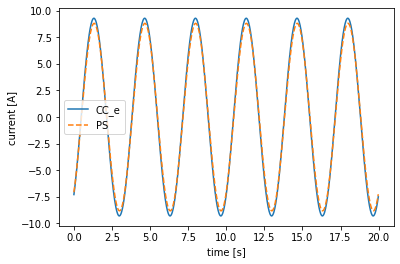

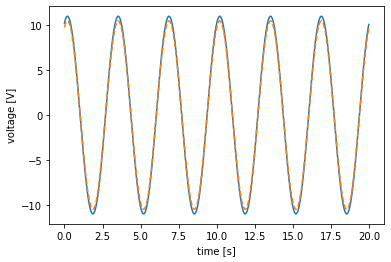

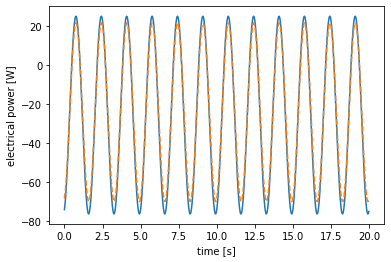

In [10]:
nsubsteps = 10
t = wec.make_time_vec(nsubsteps)

# plot electrical power
plt.figure()
plt.plot(t, cc_current_td(t), '-', label='CC_e')
plt.plot(t, pto.electric_current(
    wec, x_wec, x_opt, nsubsteps), '--', label='PS')
plt.xlabel('time [s]')
plt.ylabel('current [A]')
plt.legend()

plt.figure()
plt.plot(t, cc_voltage_td(t), '-')
plt.plot(t, pto.electric_voltage(wec, x_wec, x_opt, nsubsteps), '--')
plt.xlabel('time [s]')
plt.ylabel('voltage [V]')

plt.figure()
plt.plot(t, cc_current_td(t)*cc_voltage_td(t), '-')
plt.plot(t, pto.electric_power(wec, x_wec, x_opt, nsubsteps), '--')
plt.xlabel('time [s]')
plt.ylabel('electrical power [W]')

In [19]:
current, voltage = pto._split_vars(pto._calc_elec_vars(pto._calc_mech_vars(wec, x_wec, x_opt)))

In [20]:
current_org = np.array([-2.23262528e-09, -1.38802751e-09,  5.83283764e-10,  8.34197222e-10,
               -6.98708015e-10,  4.96258703e-10,  6.32534499e-10,  1.92486935e-09,
               -7.78939655e-11, -2.00941245e-10, -7.28464192e+00,  5.76695312e+00,
               -5.64647860e-10, -6.95386493e-10, -2.91527426e-10,  3.95616626e-11,
               -1.46869315e-09, -1.24686976e-09, -1.19394600e-09, -6.94663056e-10,
               -1.09286433e-10, -4.50982202e-10, -4.74777932e-11,  2.57805599e-11,
               -3.36323966e-11,  8.14689671e-12, -2.99382476e-10, -5.17017231e-12,
               8.69863143e-11,  3.14535146e-11,  6.06300264e-11, -8.83657747e-11,
               4.23170919e-10, -9.26091062e-10,  6.61130213e-10, -6.10000486e-10,
               -3.58568994e-10, -1.36338596e-09,  1.93899001e-10, -8.85195206e-10,
               -7.89266025e-10, -2.56747878e-10, -2.36981409e-09,  2.00505895e-09,
               -3.20745930e-09, -3.96583350e-09,  4.94392410e-09, -3.37979644e-10,
               -2.92523077e-08, -3.47532693e-07,  7.28495070e-09,  9.49893384e-10,
               2.02338003e-07,  1.82424688e-07,  5.60452025e-07, -7.84848447e-07,
               4.24700675e-09, -2.56450170e-07, -4.43364996e-08, -4.80702817e-08,
               -1.63106858e-08, -9.97650888e-09, -1.36738326e-07,  1.65779743e-07,
               8.86737321e-08, -3.61964967e-08, -5.57852523e-08,  2.48108568e-08,
               -2.26740921e-07, -2.43714122e-07,  1.80573195e-08, -1.21431174e-07,
               5.03916026e-09,  2.31151179e-07,  3.03432480e-07,  1.92047984e-07,
               1.16240306e-07,  4.87437895e-08, -1.30430428e-07, -1.01739470e-07,
               -1.11780324e-07,  6.98587712e-08, -7.90978944e-09,  5.52204416e-07,
               1.62020597e-08,  3.28549060e-08,  5.82117372e-07,  3.70230040e-07,
               7.48761562e-09, -2.09133939e-07, -1.39245430e-07,  2.31977091e-07,
               8.95824148e-08,  1.13704723e-09,  2.33712394e-08,  1.55698581e-07,
               1.84449871e-07,  3.52957042e-07,  3.37469204e-07, -7.70831788e-07])


In [14]:
np.max(current), np.min(current)

(5.272820049115513, -7.060719435844056)

In [15]:
np.max(current_org), np.min(current_org)

(5.76695312, -7.28464192)

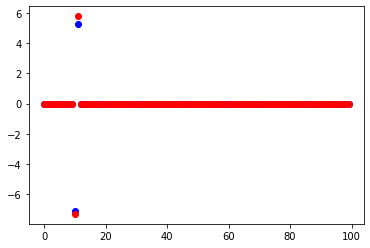

In [16]:
plt.figure()
plt.plot(current, 'bo')
plt.plot(current_org, 'ro')